In [1]:

import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import backend as K
import PIL
from IPython.display import clear_output
import matplotlib.pyplot as plt
import skimage
import random

import os

2024-02-10 22:27:44.792784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 22:27:44.792919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 22:27:45.064114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (256,256)

In [3]:
train_image_dir = "/kaggle/input/airbus-ship-detection/train_v2"
train_encode_file = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"
test_image_dir= "/kaggle/input/airbus-ship-detection/test_v2"

In [4]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    if rle_code ==0:
        return [(0,0)]
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels




In [5]:
df = pd.read_csv(train_encode_file, index_col=0).fillna('0')
df

,EncodedPixels
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...
fffedbb6b.jpg,0
ffff2aa57.jpg,0
ffff6e525.jpg,0


**Mask example**

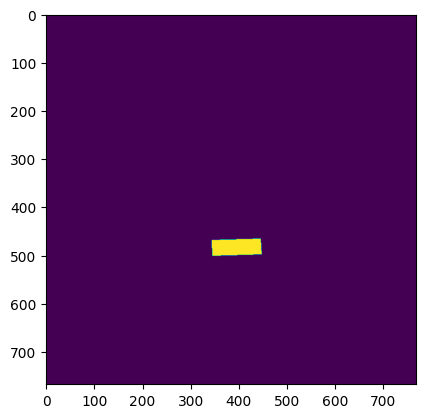

In [6]:

canvas = np.zeros((768, 768))

pixels = rle_to_pixels(df['EncodedPixels']['000155de5.jpg'])
canvas[tuple(zip(*pixels))] = 1

plt.imshow(canvas);

In [7]:
df = df.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()

load_img = lambda filename: np.array(PIL.Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/{filename}"))

def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image



In [32]:
df.loc[df['EncodedPixels'] == '0', 'ship'] = 0 
df.loc[df['EncodedPixels'] != '0', 'ship'] = 1 
df.sort_values(by=['ship'])
df.value_counts('ship')[1]

42556

<BarContainer object of 2 artists>

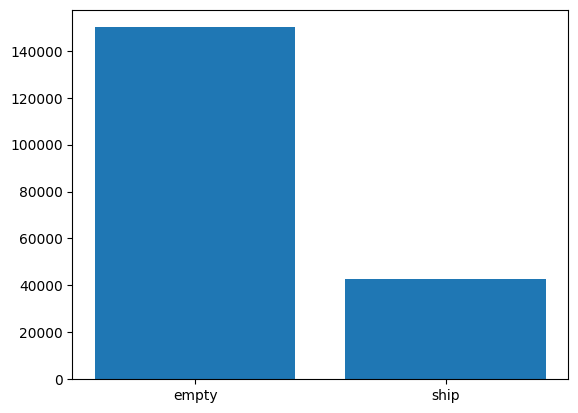

In [33]:
plt.bar(["empty",'ship'],df.value_counts('ship'),)

In [9]:
empty = df[df['ship'] == 0]
empty = empty.reset_index()
empty.head()

,index,ImageId,EncodedPixels,ship
0,0,00003e153.jpg,0,0.0
1,1,0001124c7.jpg,0,0.0
2,4,0001b1832.jpg,0,0.0
3,7,0002d0f32.jpg,0,0.0
4,8,000303d4d.jpg,0,0.0


In [10]:
ships = df[df['ship'] == 1]
ships = ships.reset_index()
ships.head()

,index,ImageId,EncodedPixels,ship
0,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1.0
1,3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1.0
2,5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,1.0
3,6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,1.0
4,9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1.0


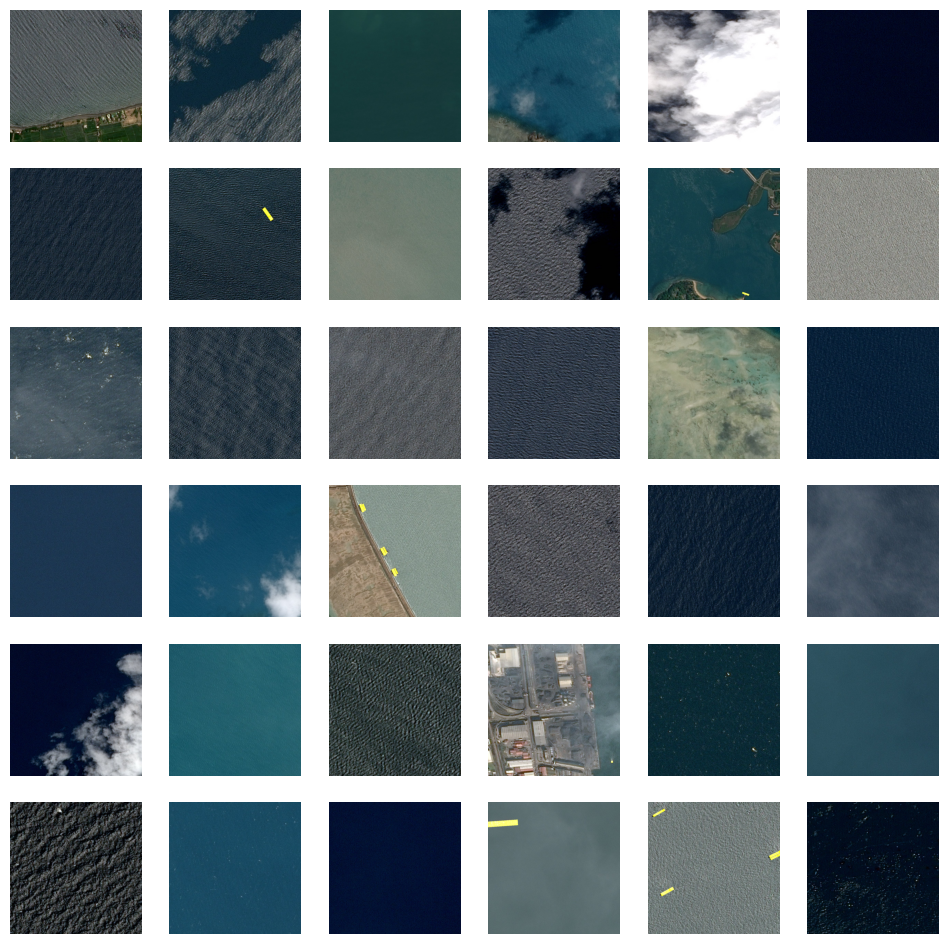

In [11]:
w = 5
h = 5

_, axes_list = plt.subplots(h, w, figsize=(2*w, 2*h))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(df)) # take a random row from the df
        ax.imshow(apply_mask(load_img(df.loc[row_index, 'ImageId']), rle_to_pixels(df.loc[row_index, 'EncodedPixels'])))

In [12]:

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  


In [13]:
def normalize(input_image,input_mask):
    input_image = tf.cast(input_image,tf.float32) / 255.0
    return input_image, input_mask

In [14]:
def get_image(index,df):
    input_image = load_img(df.loc[index, 'ImageId'])
    input_image= tf.image.resize(input_image, IMG_SIZE,method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
   
    mask_pixels = rle_to_pixels(df.loc[index, 'EncodedPixels'])
    canvas = np.zeros((768,768))
    canvas[tuple(zip(*mask_pixels))] = 1
    input_mask = skimage.transform.resize(canvas, output_shape=IMG_SIZE+(1,), mode='constant', preserve_range=True) 
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [15]:
def get_data(start_index, end_index,df):
    x = []
    y = []
    for i in range(start_index, end_index):
        im,msk = get_image(i,df)
        x.append(im)
        y.append(msk)
    return x,y






In [16]:
x_clr,y_clr = get_data(0,50,empty)
x,y = get_data(0,2000,ships)
X_train = np.concatenate((np.array(x_clr),np.array(x)),axis=0)
y_train = np.concatenate((np.array(y_clr),np.array(y)),axis=0)

In [17]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [18]:
x,y = get_data(2000,2200,ships)
X_test = np.array(x)
y_test = np.array(y)

**Dice Loss implementation**

In [19]:
def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


def dice_coef_loss(y_true, y_pred, smooth=10e-6):
    return 1 - dice_coef(y_true, y_pred , smooth)

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    sample_image = X_test[1]
    sample_mask = y_test[1]
    prediction = model.predict(sample_image[tf.newaxis, ...])[0]
    prediction = (prediction>0.5).astype(np.uint8)
    display([sample_image,sample_mask,prediction])
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model.hdf5",
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

**Model architecture**
https://arxiv.org/pdf/1505.04597.pdf?ref=machinelearningnuggets.com

In [21]:
num_classes = 1

inputs = tf.keras.layers.Input(IMG_SIZE+(3,))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy'])

1/1 [==============================] - 4s 4s/step


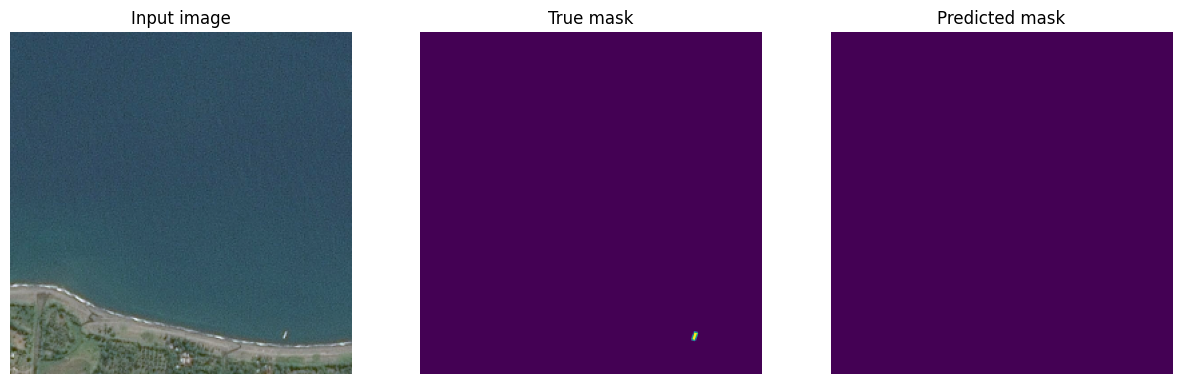

In [22]:
index = random.randint(0, len(X_test))
sample_image = X_test[index]
sample_mask = y_test[index]
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction>0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

In [23]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        DisplayCallback(),
        cp_callback
]

1/1 [==============================] - 0s 29ms/step


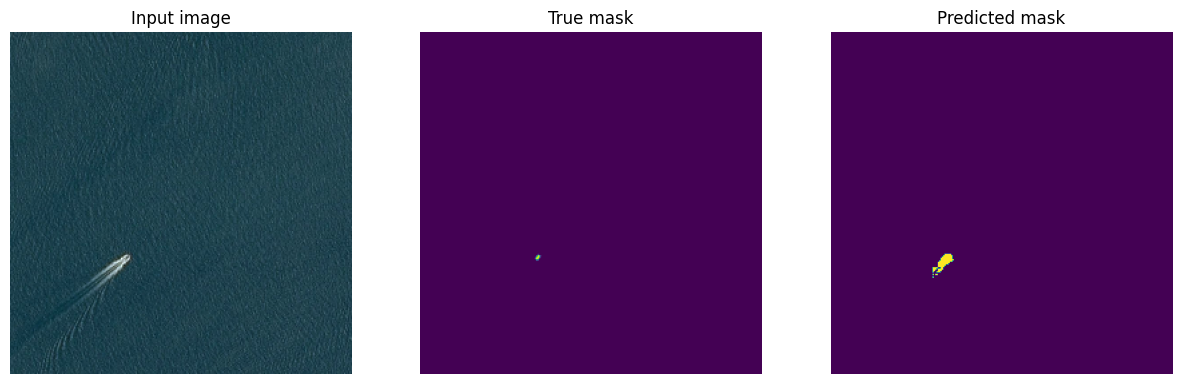


Sample Prediction after epoch 40


Epoch 40: val_loss did not improve from 0.51112
103/103 [==============================] - 16s 156ms/step - loss: 0.5131 - accuracy: 0.9697 - val_loss: 0.5218 - val_accuracy: 0.9700


In [24]:
history = model.fit(X_train, y_train, validation_split= 0.2, batch_size=16, epochs=40, callbacks=callbacks)

In [25]:
model.save_weights('my_model_weights.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


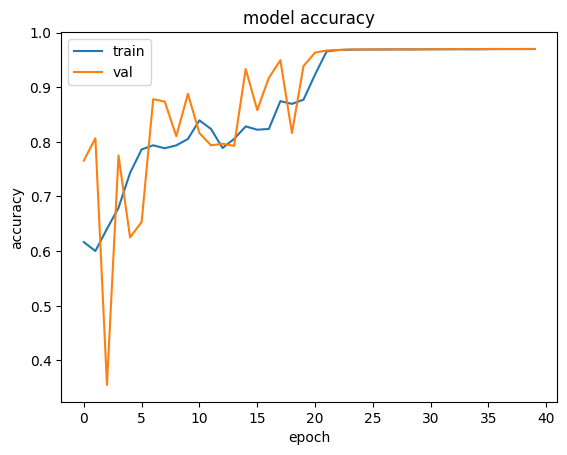

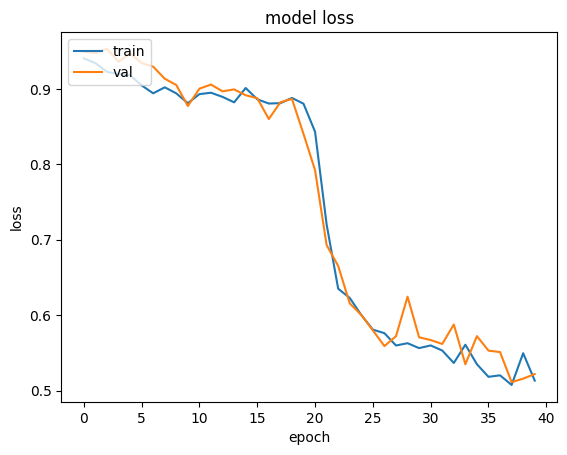

In [26]:

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#  loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()